In [1]:
import geogridfusion
import numpy as np
import geopandas as gpd
import geodatasets as gds
import matplotlib.pyplot as plt
from shapely.geometry import Point

from scipy.spatial import cKDTree

import os
import pickle

<Axes: >

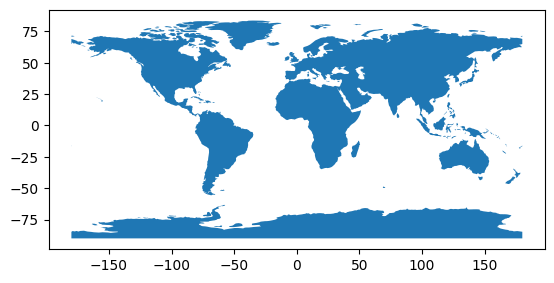

In [2]:
fp = gds.get_path("naturalearth.land")

world = gpd.read_file(fp)
world.plot()

In [6]:
points = geogridfusion.index.generate_spherical_grid_fixed(4)

aoi_geom = world.union_all()

# Simplify the AOI geometry to speed up spatial operations
aoi_geom_simplified = aoi_geom.simplify(tolerance=0.01, preserve_topology=True)
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi_geom_simplified], crs="EPSG:4326")

# Extract latitude and longitude from points
lats, lons = points[:, 0], points[:, 1]

# Create a GeoDataFrame from the points
gdf_points = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(lons, lats),  # Vectorized point creation
    crs="EPSG:4326"  # Assuming WGS84 CRS
)

# Perform spatial filtering
# gdf_points = gdf_points[gdf_points.geometry.within(aoi_geom_simplified)]
gdf_points = gpd.sjoin(gdf_points, aoi_gdf, how="inner", predicate="within")

# Result: Filtered GeoDataFrame
# gdf_points.plot()

In [7]:
# numpy lexsort is the optimal way to do this
gdf_points["latitude"] = gdf_points.geometry.y
gdf_points["longitude"] = gdf_points.geometry.x

sorted_gdf_points = gdf_points.sort_values(by=["latitude", "longitude"], ascending=[True, True])

gdf_points.index = np.arange(len(gdf_points))

In [8]:
land_lats = gdf_points.geometry.y.values
land_lons = gdf_points.geometry.x.values

land_coords = np.column_stack((land_lats, land_lons))

In [9]:
with open("4km-points.npz", "wb") as fp:
    np.savez_compressed(fp, land_coords)

In [18]:
with open(os.path.join(geogridfusion.TREE_BINARIES_DIR, "10km-points.npz"), "rb") as fp:
    npz_file = np.load(fp)
    grid_points = npz_file["arr_0"]  # Access the explicitly saved array, using default key

In [5]:
search = np.array([[1, 2], [2, 3]])

geogridfusion.index.coords_to_unique_index(
    coords=search, grid_points_fn="10km-points.npz"
)

array([523010, 511136], dtype=int64)